In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from matplotlib import ticker
from glob import glob
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [3]:
files = glob("../datas/报警记录/*.csv")
dfs = []

for file in files:
    df = pd.read_csv(file, encoding='gbk')
    dfs.append(df)

warn_df = pd.concat(dfs, ignore_index=True)

In [4]:
warn_df

,开始时间,结束时间,报警代码,ErrorDetail,报警详情,报警分类,持续时间,工站
0,2025/6/16 8:07:40,2025/6/16 8:07:40,F01ESSE-01-03,Emergency stop alarm,设备急停报警,Safety Error,0.21,S4
1,2025/6/16 8:30:55,2025/6/16 8:30:56,N03IPPO-79-03,PC Communication Abnormality,上位机通讯异常,Software Error,1.28,S2
2,2025/6/16 8:32:47,2025/6/16 8:33:01,V01VSDV-132-03,Popup:Platform1 CHG Assembly Top Photography F...,弹窗:组CHG上相机拍照失败1,Vision Error,14.00,S2
3,2025/6/16 8:33:02,2025/6/16 8:34:11,V01VSDV-132-03,Popup:Platform1 CHG Assembly Top Photography F...,弹窗:组CHG上相机拍照失败1,Vision Error,69.13,S2
4,2025/6/16 9:38:05,2025/6/16 9:38:06,M99EEDE-10-03,Platform 1X-axis alarm,平台1X轴报警,Motion Error,0.86,S4
...,...,...,...,...,...,...,...,...
386,2025/6/28 16:16:53,2025/6/28 16:16:57,V01VSDV-131-03,Popup:Platform1 SPK Assembly Top Photography F...,弹窗:组SPK上相机拍照失败1,Vision Error,4.62,S2
387,2025/6/28 16:23:12,2025/6/28 16:23:16,V01VSDV-131-03,Popup:Platform1 SPK Assembly Top Photography F...,弹窗:组SPK上相机拍照失败1,Vision Error,3.96,S2
388,2025/6/28 16:23:16,2025/6/28 16:23:50,V01VSDV-131-03,Popup:Platform1 SPK Assembly Top Photography F...,弹窗:组SPK上相机拍照失败1,Vision Error,33.81,S2
389,2025/6/28 16:27:32,2025/6/28 16:27:34,F01ESSE-01-03,Emergency Stop Alarm,设备急停报警,Safety Error,2.22,S2


In [19]:
warn_df['开始时间'] = pd.to_datetime(warn_df['开始时间'])
warn_df['日期'] = warn_df['开始时间'].dt.date
warn_df_use = warn_df[(warn_df['日期'] > pd.to_datetime('2025-06-23').date()) & (warn_df['持续时间'] < 20000)]
# warn_df.to_csv("../files/warnlog.csv", index=False)

In [34]:
# 报警统计函数
def generate_alarm_stats(df: pd.DataFrame):
    # 按日期和报警分类统计
    alarm_stats = df.groupby(['日期', '报警分类']).agg(
        报警次数=('报警分类', 'count'),
        总持续时间=('持续时间', 'sum'),
        平均持续时间=('持续时间', 'mean'),
        最长持续时间=('持续时间', 'max')
    ).reset_index()
    
    # 计算报警总次数和总持续时间
    date_stats = df.groupby('日期').agg(
        总报警次数=('报警分类', 'count'),
        总持续时间=('持续时间', 'sum'),
        平均持续时间=('持续时间', 'mean')
    ).reset_index()
    
    # 按工站统计
    station_stats = df.groupby(['日期', '工站']).agg(
        工站报警次数=('报警分类', 'count'),
        工站持续时间=('持续时间', 'sum')
    ).reset_index()
    
    return alarm_stats, date_stats, station_stats

alarm_stats, date_stats, station_stats = generate_alarm_stats(warn_df_use)

In [35]:
# 整理日期列表（确保排序）
dates = sorted(warn_df_use['日期'].unique())

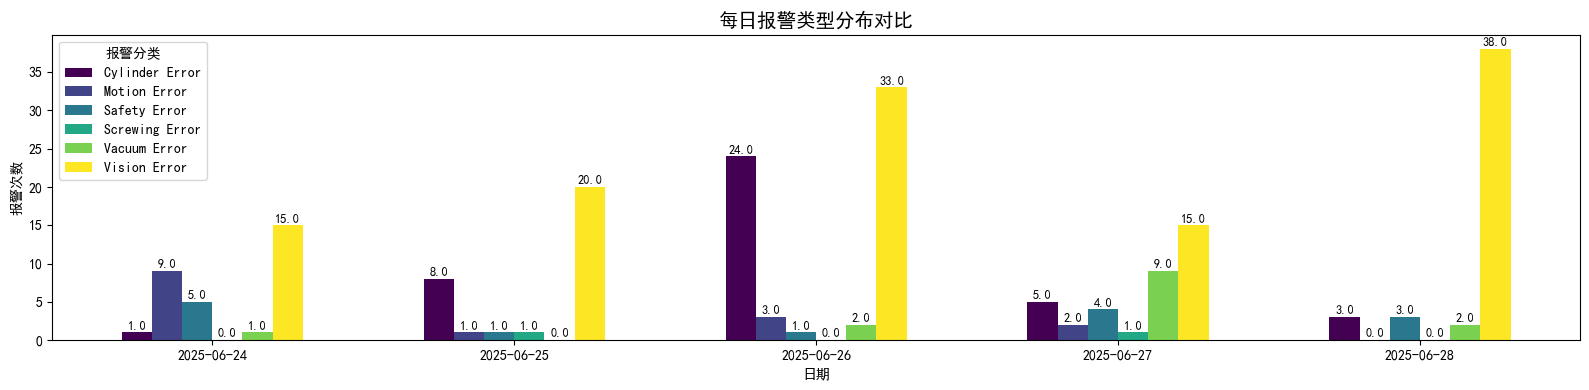

In [22]:
# 图表2: 报警类型分布对比（每日）
plt.figure(figsize=(16, 4), dpi=100)
plt.title('每日报警类型分布对比', fontsize=14)

# 准备数据透视表
pivot_df = alarm_stats.pivot(index='日期', columns='报警分类', values='报警次数').fillna(0).loc[dates]

# 绘制分组柱状图
x = np.arange(len(dates))
width = 0.1  # 每组柱状图宽度

colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(pivot_df.columns)))

for i, category in enumerate(pivot_df.columns):
    positions = x + i * width
    plt.bar(positions, pivot_df[category], width, label=category, color=colors[i])
    
    # 添加数据标签
    for j, value in enumerate(pivot_df[category]):
        plt.text(positions[j], value + 0.1, f"{value}", 
                ha='center', va='bottom', fontsize=9)

plt.xticks(x + (len(pivot_df.columns)-1)/2 * width, dates)
plt.xlabel('日期')
plt.ylabel('报警次数')
plt.legend(title='报警分类')

plt.tight_layout()
# plt.savefig('Alarm_Type_Distribution.png', dpi=300)
plt.show()

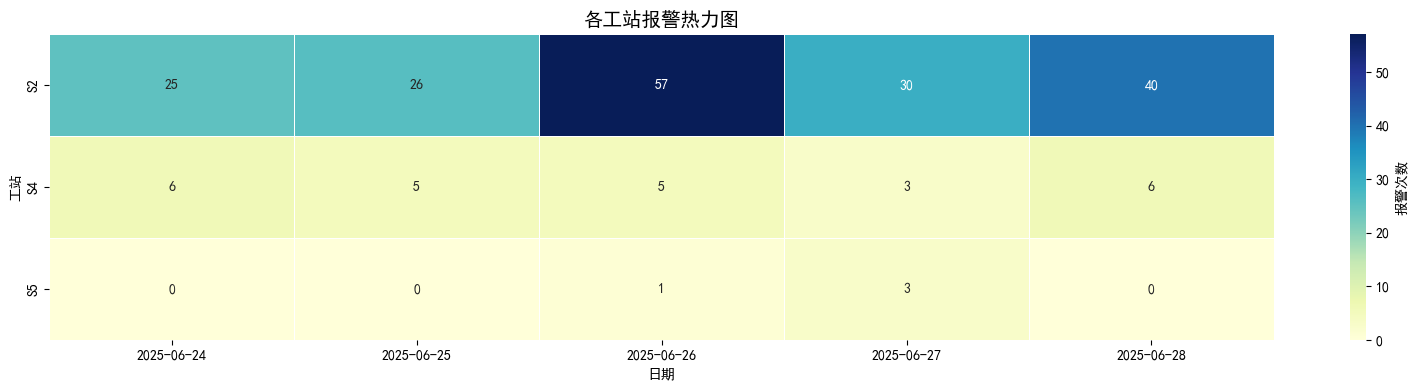

In [23]:
# 图表3: 工站报警热力图
plt.figure(figsize=(16, 4), dpi=100)
plt.title('各工站报警热力图', fontsize=14)

# 准备工站数据
station_pivot = station_stats.pivot_table(index='工站', columns='日期', values='工站报警次数', fill_value=0).loc[:, dates]

# 绘制热力图
sns.heatmap(station_pivot, annot=True, fmt='.0f', cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': '报警次数'})
plt.xlabel('日期')
plt.ylabel('工站')

plt.tight_layout()
# plt.savefig('Station_Alarm_Heatmap.png', dpi=300)
plt.show()

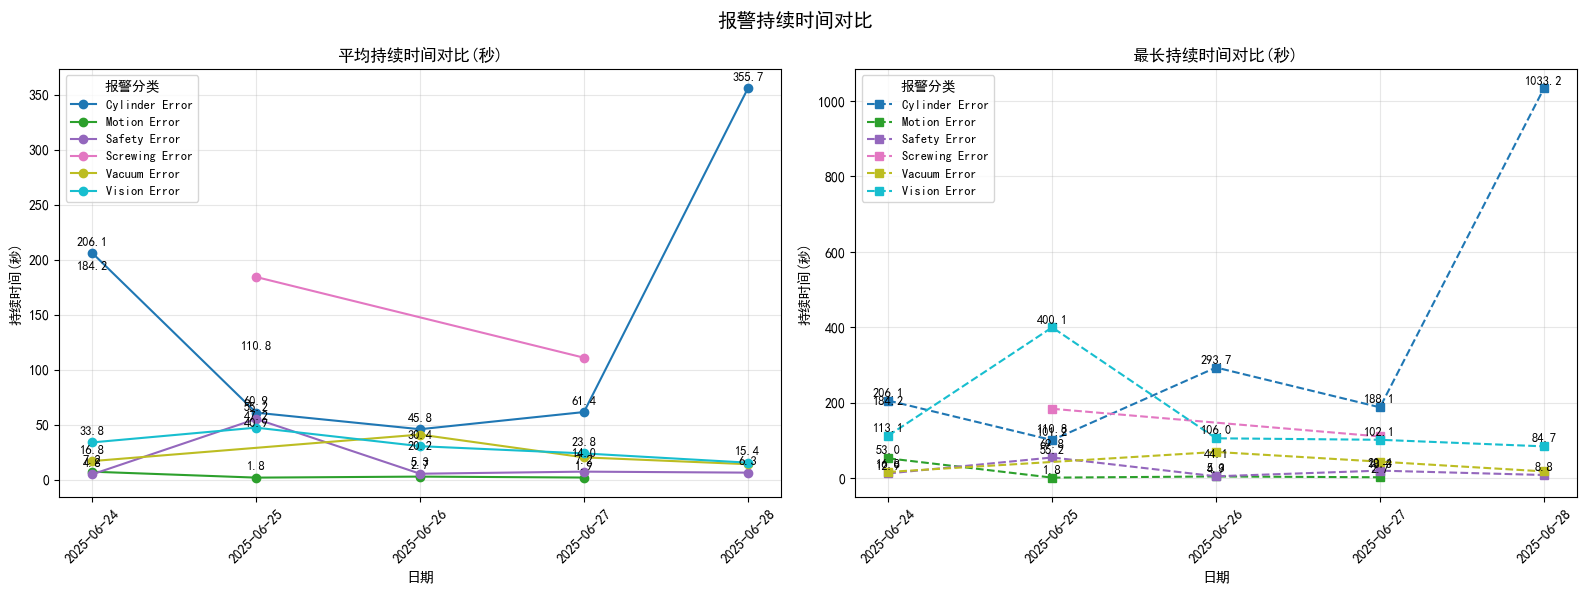

In [24]:
# 图表4: 持续时间对比
fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle('报警持续时间对比', fontsize=14)

# 准备持续时间数据
avg_duration = alarm_stats.groupby(['日期', '报警分类'])['平均持续时间'].mean().unstack().loc[dates]
max_duration = alarm_stats.groupby(['日期', '报警分类'])['最长持续时间'].max().unstack().loc[dates]

# 图表4a: 平均持续时间对比
ax[0].set_title('平均持续时间对比(秒)')
colors = plt.get_cmap('tab10')(np.linspace(0, 1, len(avg_duration.columns)))

x = np.arange(len(dates))

for i, category in enumerate(avg_duration.columns):
    # 跳过值为0的日期
    non_zero_idx = avg_duration[category] > 0
    ax[0].plot(np.array(x)[non_zero_idx], avg_duration[category][non_zero_idx], 
             'o-', label=category, color=colors[i])
    
    # 添加数据标签
    for j, val in enumerate(avg_duration[category][non_zero_idx]):
        ax[0].text(x[j], val + 5, f"{val:.1f}", 
                 ha='center', va='bottom', fontsize=9)

ax[0].set_xticks(x)
ax[0].set_xticklabels(dates, rotation=45)
ax[0].set_xlabel('日期')
ax[0].set_ylabel('持续时间(秒)')
ax[0].grid(True, alpha=0.3)
ax[0].legend(title='报警分类', fontsize=9)

# 图表4b: 最长持续时间对比
ax[1].set_title('最长持续时间对比(秒)')
for i, category in enumerate(max_duration.columns):
    # 跳过值为0的日期
    non_zero_idx = max_duration[category] > 0
    ax[1].plot(np.array(x)[non_zero_idx], max_duration[category][non_zero_idx], 
             's--', label=category, color=colors[i])
    
    # 添加数据标签
    for j, val in enumerate(max_duration[category][non_zero_idx]):
        ax[1].text(x[j], val + 5, f"{val:.1f}", 
                 ha='center', va='bottom', fontsize=9)

ax[1].set_xticks(x)
ax[1].set_xticklabels(dates, rotation=45)
ax[1].set_xlabel('日期')
ax[1].set_ylabel('持续时间(秒)')
ax[1].grid(True, alpha=0.3)
ax[1].legend(title='报警分类', fontsize=9)

plt.tight_layout()
# plt.savefig('Alarm_Duration_Comparison.png', dpi=300)
plt.show()

warn_df_use[warn_df_use['日期'] == pd.to_datetime('2025-06-24').date()]

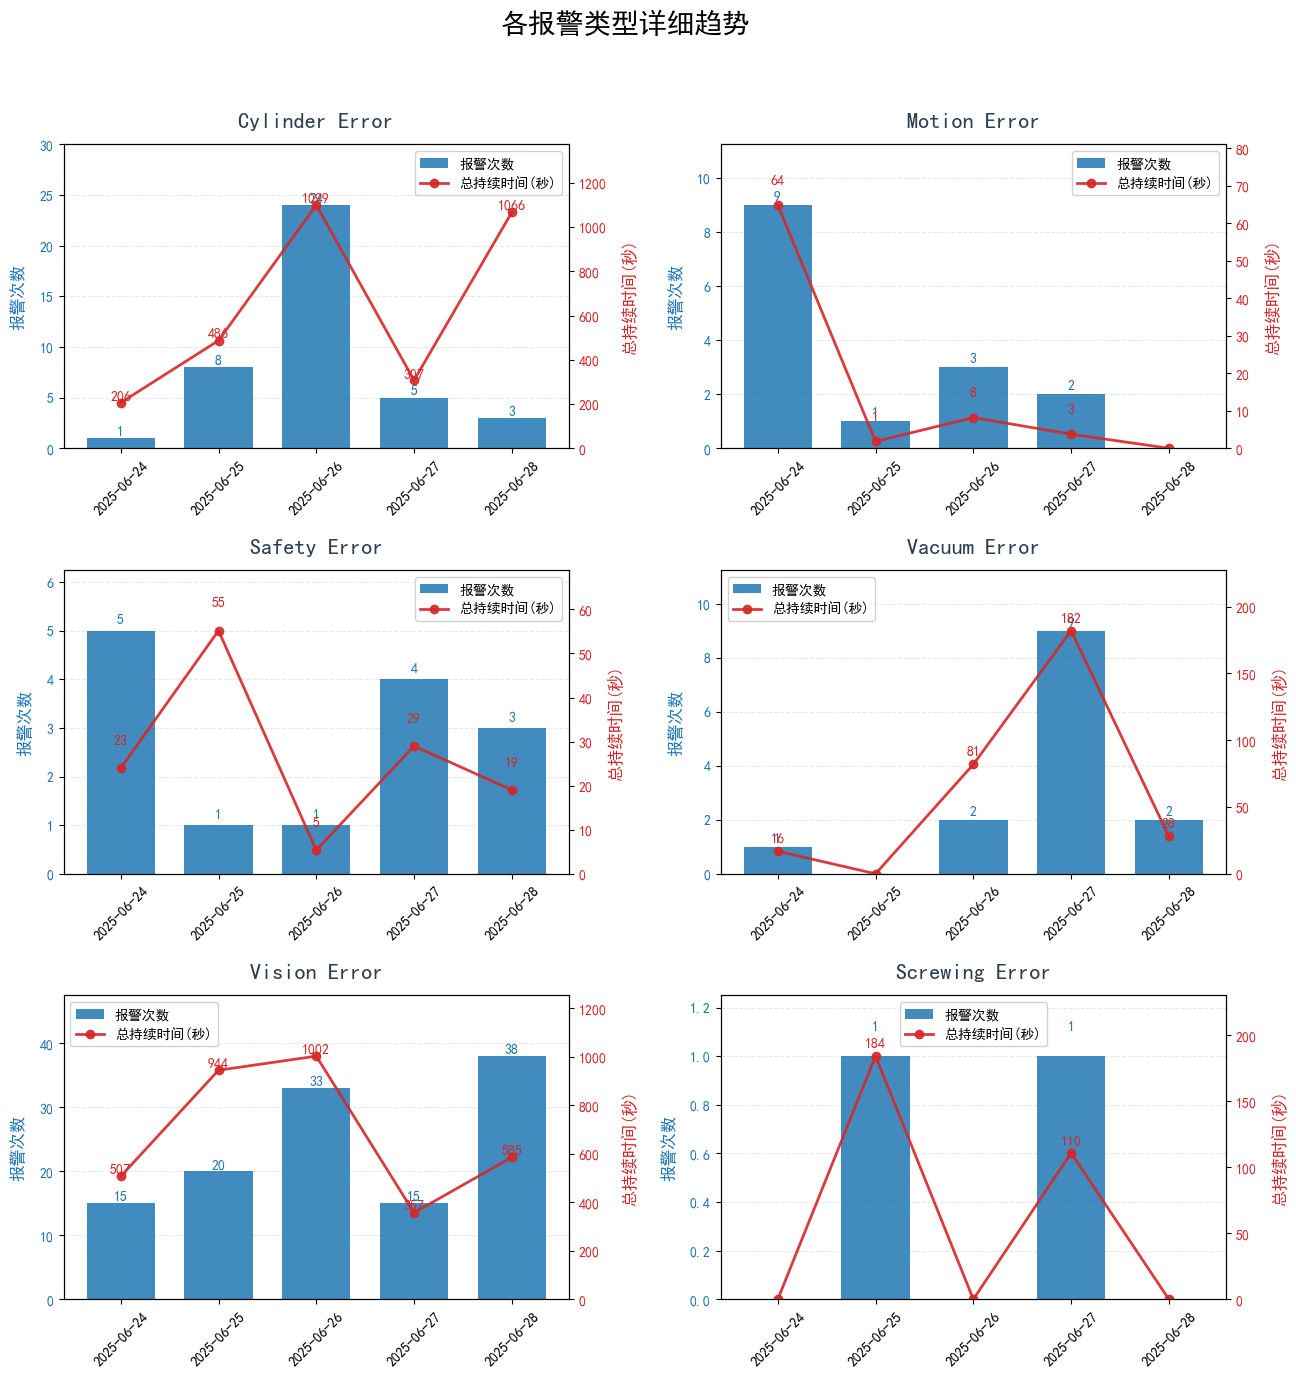

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator

def optimize_alarm_plot(alarm_stats, dates):
    """
    优化后的报警类型趋势图绘制函数
    修复运行时间长和显示不完整的问题
    """
    # 1. 一次性预处理所有数据 - 减少重复计算
    alarm_types = alarm_stats['报警分类'].unique()
    all_data = []
    
    # 创建完整的日期类型组合
    for a_type in alarm_types:
        type_df = alarm_stats[alarm_stats['报警分类'] == a_type]
        existing_dates = type_df['日期'].unique()
        
        # 创建缺失日期的数据框
        missing_dates = np.setdiff1d(dates, existing_dates)
        if len(missing_dates) > 0:
            missing_df = pd.DataFrame({
                '日期': missing_dates,
                '报警分类': a_type,
                '报警次数': 0,
                '总持续时间': 0
            })
            type_df = pd.concat([type_df, missing_df])
        
        type_df['日期'] = pd.Categorical(type_df['日期'], categories=dates, ordered=True)
        type_df = type_df.sort_values('日期')
        all_data.append(type_df)
    
    complete_df = pd.concat(all_data)
    
    # 2. 优化子图布局 - 根据报警类型数量自动调整
    n_types = len(alarm_types)
    n_cols = 2
    n_rows = int(np.ceil(n_types / n_cols))
    
    # 3. 创建专业图表布局
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), 
                            gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
    axes_flat = axes.flatten() if n_rows > 1 else [axes]
    
    fig.suptitle('各报警类型详细趋势', fontsize=20, fontweight='bold', y=0.97)
    
    # 专业配色方案
    palette = {
        'bar': '#1f77b4',    # 蓝色柱状图
        'line': '#d62728',   # 红色折线图
        'text': '#2c3e50'    # 深灰色文字
    }
    
    # 4. 优化每个子图的绘制
    for i, a_type in enumerate(alarm_types):
        ax = axes_flat[i]
        type_data = complete_df[complete_df['报警分类'] == a_type].copy()
        
        # 确保正确的日期顺序
        type_data['date_index'] = np.arange(len(type_data))
        
        # 报警次数柱状图
        bars = ax.bar(type_data['date_index'], type_data['报警次数'], 
                     color=palette['bar'], alpha=0.85, width=0.7)
        
        # 添加柱状图标签（仅显示非零值）
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.1,
                       f'{int(height)}', 
                       ha='center', va='bottom',
                       fontsize=10, color=palette['bar'])
        
        # 总持续时间折线图（次坐标轴）
        ax2 = ax.twinx()
        line, = ax2.plot(type_data['date_index'], type_data['总持续时间'], 
                        'o-', linewidth=2, markersize=6,
                        color=palette['line'], alpha=0.9)
        
        # 添加折线标签（仅显示非零值）
        for x, y in zip(type_data['date_index'], type_data['总持续时间']):
            if y > 0:
                ax2.text(x, y + 5, f"{int(y)}", 
                        ha='center', va='bottom',
                        fontsize=10, color=palette['line'])
        
        # 5. 优化坐标轴和标题
        ax.set_title(a_type, fontsize=16, pad=12, color=palette['text'])
        ax.set_ylabel('报警次数', fontsize=12, color=palette['bar'], labelpad=10)
        ax.tick_params(axis='y', labelcolor=palette['bar'])
        
        ax2.set_ylabel('总持续时间(秒)', fontsize=12, color=palette['line'], labelpad=10)
        ax2.tick_params(axis='y', labelcolor=palette['line'])
        
        # 设置优化的X轴日期显示
        n_ticks = min(8, len(dates))  # 最多显示8个日期标签
        ax.xaxis.set_major_locator(MaxNLocator(n_ticks, integer=True))
        ax.set_xticks(np.linspace(0, len(dates)-1, n_ticks, dtype=int))
        ax.set_xticklabels([dates[i] for i in ax.get_xticks()], rotation=45)
        
        # 6. 优化网格和空间布局
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)  # 网格线在图表元素下方
        
        # 动态调整Y轴范围
        if type_data['报警次数'].max() > 0:
            ax.set_ylim(0, type_data['报警次数'].max() * 1.25)
        if type_data['总持续时间'].max() > 0:
            ax2.set_ylim(0, type_data['总持续时间'].max() * 1.25)
        
        # 7. 添加智能图例（避免重叠）
        if type_data['报警次数'].max() > 0 and type_data['总持续时间'].max() > 0:
            ax.legend([bars, line], ['报警次数', '总持续时间(秒)'], frameon=True, framealpha=0.9)
    
    # 8. 隐藏未使用的子图
    for j in range(i+1, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    # 9. 优化整体布局
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # 为标题留出空间
    
    return fig

fig = optimize_alarm_plot(alarm_stats, dates)
plt.show()